# HW4: Applied Transport Phenomena  

What is our goal? 

Solve various forms of the convection-diffusion equation. Possible even add a reaction term; 

We expect to go through the following stages: 
1. extend 1D (only x) diffusion equation (HW1) to the convection-diffusion equation; 
2. extend linear convection (prescribed(u) times ux) to non-linear convection-diffusion (u times ux); 
3. extend from 1D (only x) to 2D (both x and y);
4. extend from stationary (time independent) to transient (time dependent); 
5. extend from single component (only u(x) or u(x,y)) to (both u(x,y) and v(x,y)); (potential flow, Stokes, laminar Navier-Stokes); 

## Import Libraries

In [2]:
import numpy as np
print("Succesfully imported %s -- Version: %s"%(np.__name__,np.__version__))
import scipy
print("Succesfully imported %s -- Version: %s"%(scipy.__name__,scipy.__version__))
import matplotlib.pyplot as plt
print("Succesfully imported %s"%plt.__name__)
import pandas as pd
print("Succesfully imported %s -- Version: %s"%(pd.__name__,pd.__version__))
import sympy as sym 
print("Succesfully imported %s -- Version: %s"%(sym.__name__,sym.__version__))
from scipy import optimize
print("Succesfully imported %s"%optimize.__name__)
from scipy.optimize import fsolve
print("Succesfully imported %s"%fsolve.__name__)
from scipy.signal import find_peaks
print("Succesfully imported %s"%find_peaks.__name__)
from scipy.linalg import orth
print("Succesfully imported %s"%orth.__name__)
from scipy.integrate import odeint
print("Succesfully imported %s"%odeint.__name__)

Succesfully imported numpy -- Version: 1.20.1
Succesfully imported scipy -- Version: 1.6.2
Succesfully imported matplotlib.pyplot
Succesfully imported pandas -- Version: 1.2.4
Succesfully imported sympy -- Version: 1.8
Succesfully imported scipy.optimize
Succesfully imported fsolve
Succesfully imported find_peaks
Succesfully imported orth
Succesfully imported odeint


## Section 1/: Introduction and Model Description

Describe the Brusselator model as ODE (see wiki), a PDE in one spatial dimensions [see here](https://rveltz.github.io/BifurcationKit.jl/dev/tutorials/tutorials3/#d-Brusselator-(automatic)) (possiby better references do exist) and as PDE in two spatial dimensions (see above, and book by Hairer and Wannes Part 2).  

## Section 2/: Convection-Diffusion Equation in 1D

### Section 2.1/: Problem statement 

We aim at solving the convection-diffusion equation on the interval $0 \leq x \leq 1$. Our objective is to numerically approximate the function $u(x)$ that is the solution of the following problem.

\begin{equation}
 -ε\frac{\text{d}^2u}{\text{d}x^2}+\frac{\text{d}u}{\text{d}x} = 0 \tag{1}
\end{equation}

where the first term will be referred to as the "diffusion term" and the second one will be referred to as the "convective term". 

Given the small positive number  $ε > 0$, find the function $u(x)$ that is the solution of the differential equation written above, supplied with the following non-homogeneous Dirichlet boundary condition in $x = 0$ and homogeneous Dirichlet boundary condition in $x = 1$:

\begin{equation}
 u(x=0)=1  \text{          and         }  u(x=1)=0 \tag{2}
\end{equation}

Compared to the tutorial of this week, we now added a convective term and set the source term equal zero. The latter was done to simplify matters for the time being. The number $ε$ is the relative weight of the diffusion
and the convective term in the differential equation. The number $ε$ plays an important role in the practice of a computational chemical engineer. It will reappear in later courses under the aliases such as the Peclet or
Reynolds number. The solution $u(x)$ clearly depends on the value of $ε$.

#### Analytical Reference Solution 
The differential equation $(1)$ supplied with the boundary conditions $(2)$
can be solved analytically by first supposing that u(x) = exp(r x), solving the characteristic equation $-ε r^2 +r = 0$ for $r$, setting $u(x) = C_{1} exp(r_{1} x)+C_{2} exp(r_{2} x)$ and using the boundary conditions to find
$C_{1}$ and $C_{2}$. Doing so, one finds the solution:


\begin{equation}
 u(x)=\frac{\exp (x/ε)-\exp (1/ε)}{1-\exp (1/ε)} \tag{3}
\end{equation}

#### Assignment 1

First, verify that the function $u(x)$ given by $(3)$ indeed satisfies the differential equation $(1)$ and the boundary conditions $(2)$. Please do so using pen and paper (touch screen?). The use of a symbolic
manipulation toolbox is too elaborate for this purpose. Next, plot the function $u(x)$ as a function of $x$ for $0 < x < 1$ by avoiding for-loops in Python. Compare different values for $ε$ using for instance $ε = 1/10$,
$ε = 1/50$ and $ε = 1/100$. Give a physical interpretation for the way in which $u(x)$ changes with $ε$.

U(x) changes into a sharper step function with decreasing e-values.


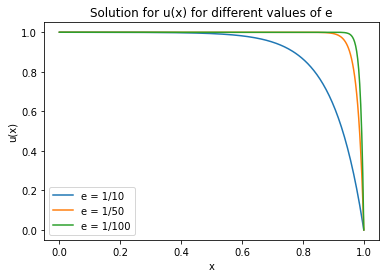

In [3]:
# First I define the function and the necessary variables
def u(x,e):
    F = (np.exp(x/e)-np.exp(1/e))/(1-np.exp(1/e))
    return F
e1 = 0.1
e2 = 1/50
e3 = 1/100
x = np.linspace(0,1,300)

# Then I plot the figures
plt.figure()
plt.plot(x, u(x,e1), label = 'e = 1/10')
plt.plot(x, u(x,e2), label = 'e = 1/50')
plt.plot(x, u(x,e3), label = 'e = 1/100')
plt.xlabel('x')
plt.ylabel('u(x)')
plt.title('Solution for u(x) for different values of e')
plt.legend(loc = 3)

print('U(x) changes into a sharper step function with decreasing e-values.')

### Section 1.2:/ Finite Difference Solution
Next we proceed with the finite difference approximation.

#### Mesh 
Assume that the interval $0 < x < 1$ is discretized by an uniform mesh consisting of $N$ elements with mesh width $h = 1=N$ and vertices $x_{i} = (i-1)h$, where $i$ runs from 1 to $N + 1$. This enumeration includes the end points of the interval, that is, $x_{1} = 0$ and $x_{N+1} = 1$. The grid nodes can then be denoted by

\begin{equation}
 G_h=\Bigg({x_{i}|x_{i}=(i-1)h; h=\frac{1}{N}, 1\leq i \leq N+1}\Bigg) \tag{4}
\end{equation}


Let $u^{h}$ denote the vector with $N+1$ components such its $i$-th component $u^{h}_{i}$ approximates the exact solution $u(x)$ in the $i$-th node.

#### Discretization of the diffusion term in the interior nodes
The differential equation holds in particular for all of the internal nodes, that is, we have that

\begin{equation}
 -ε\frac{\text{d}^2u}{\text{d}x^2}\Bigg|_{x=x_{i}}+\frac{\text{d}u}{\text{d}x}\Bigg|_{x=x_{i}} = 0 \text{  for all  } 2\leq i \leq N    \tag{5}
\end{equation}


To approximate the diffusion term, we proceed as in the tutorial and use a finite difference formula to discretize the second derivative $\frac{\text{d}^2u}{\text{d}x^2}\Bigg|_{x=x_{i}} = u''(x_{i})$ as follows

\begin{equation}
 u''(x_{i})\approx\frac{u'(x_{i}+h/2)-u'(x_{i}-h/2)}{h}    \tag{6}
\end{equation}


\begin{equation}
 u''(x_{i})\approx\frac{u(x_{i+1})-2u(x_{i})+u(x_{i-1})}{h^2}    
\end{equation}

(Using Taylor polynomials it can be shown that the local truncation error is of second order in $h$). The finite difference discretization thus leads to the following stencil for the approximation of $-ε\frac{\text{d}^2u}{\text{d}x^2}\Bigg|_{x=x_{i}}$ (beware of the minus-sign and the factor $-ε$)

\begin{equation}
 \frac{1}{h^2}\Bigg[\begin{matrix}-ε &  2ε & -ε\\ x_{i-1} & x_{i} & x_{i+1} \end{matrix}\Bigg]       \text{[central approximation for difussion]} \tag{7}
\end{equation}


This stencil implies that each node $x_{i}$ is coupled to its left ($x_{i-1}$) and right neighbour ($x_{i+1}$) with a weight of $-\frac{ε}{h^2}$.


#### Discretization of the convection term in the interior nodes 

The convective term can be approximated in two ways. The first option is to use a central approximation on neighboring nodes

\begin{equation}
 u'(x_{i})\approx\frac{u(x_{i+1})-u(x_{i-1})}{2h}   \tag{8} 
\end{equation}

leading to the stencil

\begin{equation}
 \frac{1}{2h}\Bigg[\begin{matrix}-1 &  0 & 1\\ x_{i-1} & x_{i} & x_{i+1} \end{matrix}\Bigg]       \text{[central approximation for convection]} \tag{9}
\end{equation}


(The local approximation error of this scheme is of second order in $h$. This second order comes however at an expensive that we discover later in this assignment.) The second option is to approximate the first order
derivative using the backward finite difference approximation


\begin{equation}
 u'(x_{i})\approx\frac{u(x_{i})-u(x_{i-1})}{h}   \tag{10} 
\end{equation}

In this approximation information in $x_{i-1}$ is used to approximate the derivative in $x_{i}$. In this exercise the convective term propagates information from the left to the right. The node $x_{i-1}$  thus lies upstream from $x_{i}$. The above finite difference approximation is therefore referred to as the upwind approximation. This approximation leads to the stencil


\begin{equation}
 \frac{1}{h}\Bigg[\begin{matrix}-1 & 1 & 0\\ x_{i-1} & x_{i} & x_{i+1} \end{matrix}\Bigg]       \text{[upwind approximation for convection]} \tag{11}
\end{equation}

(The local approximation of this scheme is only of first order in h. Despite this lower order of accuracy, this scheme has a distinct advantage that we will discover later in this assignment.) The stencil of the diffusive and the convective term should be added to obtain the stencil for the coefficient matrix $A^h$ corresponding to the finite difference scheme.

#### Discretization in the left and right boundary condition 
Verify that the Dirichlet boundary condition in the left and right end point can be enforced by requiring that

\begin{equation}
 u_{1}=1 \text{          and that         }       u_{N+1}=0  \tag{12}
\end{equation}

The finite difference stencil in the left and right end point thus reduces to

\begin{equation}
 \Bigg[\begin{matrix}1 & 0 & 0\\ x_{1} & x_{2} & x_{3} \end{matrix}\Bigg]   \text{          and         }    \Bigg[\begin{matrix}0 & 0 & 1\\ x_{N-1} & x_{N} & x_{N+1} \end{matrix}\Bigg] \tag{13}
\end{equation}

The non-homogeneous contribution in the left boundary condition (the term equal to 1) will be placed in the first component of the right-hand vector. The other components of this right-hand vector will remain equal to one.

#### Assignment 2 

Assume $h = 1/3$ (and thus $N=3$) and $ε = 0.5$. Assume that the central difference scheme $(8)$ is used to approximate the convective term in $(1)$. Determine the size of the global matrix $A^h$ and the global right-hand vector $f$. Give all the elements of this matrix and vector with pen (or pencil) and paper.

In [4]:
# First I define the necessary variables
e = 1/2
h = 1/3
x = np.linspace(0, 1, 4)
f = np.zeros(4)
f[0] = 1

# The convection term using central difference scheme
c1 = 1/(2*h)*np.diag(np.ones(3), k = 1)
c2 = -1/(2*h)*np.diag(np.ones(3), k = -1)

# The diffusion term 
d1 = -e/(h**2)*np.diag(np.ones(3), k = 1)
d2 = -e/(h**2)*np.diag(np.ones(3), k = -1)
d3 = 2*e/(h**2)*np.diag(np.ones(4))

# The global matrix
A = c1 + c2 + d1 + d2 + d3
A[0,0] = 1
A[0,1] = 0
A[-1,-1] = 1
A[-1,-2] = 0

# Lastly I print the results
print('The global matrix A is:')
print(A) 
print('and its size is:', np.size(A))
print('')
print('The global right-hand vector is:')
print(f)
print('with size:', np.size(f))

The global matrix A is:
[[ 1.  0.  0.  0.]
 [-6.  9. -3.  0.]
 [ 0. -6.  9. -3.]
 [ 0.  0.  0.  1.]]
and its size is: 16

The global right-hand vector is:
[1. 0. 0. 0.]
with size: 4


#### Assignment 3 

As previous assignment, this time using the upwind scheme to approximate the convective term in $(1)$.

In [5]:
# First I define the necessary variables
e = 1/2
h = 1/3
x = np.linspace(0, 1, 4)
f = np.zeros(4)
f[0] = 1

# The convection term using upwind scheme
c1 = 1/h*np.diag(np.ones(4), k = 0)
c2 = -1/h*np.diag(np.ones(3), k = -1)

# The diffusion term 
d1 = -e/(h**2)*np.diag(np.ones(3), k = 1)
d2 = -e/(h**2)*np.diag(np.ones(3), k = -1)
d3 = 2*e/(h**2)*np.diag(np.ones(4))

# The global matrix
A = c1 + c2 + d1 + d2 + d3
A[0,0] = 1
A[0,1] = 0
A[-1,-1] = 1
A[-1,-2] = 0

# Print the results
print('The global matrix A is:')
print(A) 
print('and its size is:', np.size(A))
print('')
print('The global right-hand vector is:')
print(f)
print('with size:', np.size(f))

The global matrix A is:
[[ 1.   0.   0.   0. ]
 [-7.5 12.  -4.5  0. ]
 [ 0.  -7.5 12.  -4.5]
 [ 0.   0.   0.   1. ]]
and its size is: 16

The global right-hand vector is:
[1. 0. 0. 0.]
with size: 4


#### Assignment 4

Assume $ε = 1/100$ and that the central difference scheme $(8)$ is used to approximate the convective term in $(1)$. Assemble for $h = 1/10$, $h = 1/20$ and $h = 1/100$ the global matrix $A^h$ and the
global right-hand vector $f^h$. Solve the linear system

\begin{equation}
 A^h u^h = f^h   \tag{14} 
\end{equation}


using the numpy.linalg.solve() function. Plot the various solution for $u^h$ found and compare this plot with the plot of the exact solution in Part 1.

The higher the N-value the more similar to the exact solution the approximation becomes


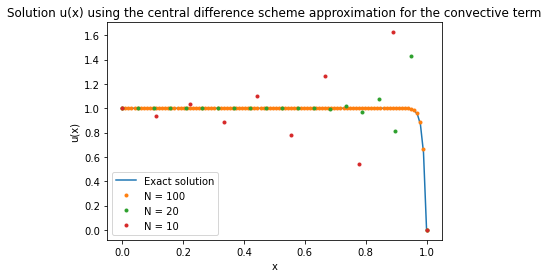

In [6]:
# First I define the function I'll use and the necessary variables
def u(x):
    F = (np.exp(x/e)-np.exp(1/e))/(1-np.exp(1/e))
    return F
e = 1/100
h = np.array([1/10, 1/20, 1/100])
x1 = np.linspace(0, 1, 100)
x2 = np.linspace(0, 1, 20)
x3 = np.linspace(0, 1, 10)

f1 = np.zeros(100)
f1[0] = 1
f2 = np.zeros(20)
f2[0] = 1
f3 = np.zeros(10)
f3[0] = 1

# The convection terms using the central difference scheme
c1 = 1/(2*h[2])*np.diag(np.ones(99),k = 1)
cc1 = -1/(2*h[2])*np.diag(np.ones(99), k = -1)

c2 = 1/(2*h[1])*np.diag(np.ones(19), k = 1)
cc2 = -1/(2*h[1])*np.diag(np.ones(19), k = -1)

c3 = 1/(2*h[0])*np.diag(np.ones(9), k = 1)
cc3 = -1/(2*h[0])*np.diag(np.ones(9), k = -1)

# The diffusion terms used for the solution
d1 = -e/(h[2]**2)*np.diag(np.ones(99), k = 1)
dd1 = -e/(h[2]**2)*np.diag(np.ones(99), k = -1)
ddd1 = 2*e/(h[2]**2)*np.diag(np.ones(100))

d2 = -e/(h[1]**2)*np.diag(np.ones(19), k = 1)
dd2 = -e/(h[1]**2)*np.diag(np.ones(19), k = -1)
ddd2 = 2*e/(h[1]**2)*np.diag(np.ones(20))

d3 = -e/(h[0]**2)*np.diag(np.ones(9), k = 1)
dd3 = -e/(h[0]**2)*np.diag(np.ones(9), k = -1)
ddd3 = 2*e/(h[0]**2)*np.diag(np.ones(10))

# The global matrices
A1 = c1 + cc1 + d1 + dd1 + ddd1
A1[0,0] = 1
A1[0,1] = 0
A1[-1,-1] = 1
A1[-1,-2] = 0

A2 = c2 + cc2 + d2 + dd2 + ddd2
A2[0,0] = 1
A2[0,1] = 0
A2[-1,-1] = 1
A2[-1,-2] = 0

A3 = c3 + cc3  + d3 + dd3 + ddd3
A3[0,0] = 1
A3[0,1] = 0
A3[-1,-1] = 1
A3[-1,-2] = 0

# Lastly I plot the functions
plt.figure()
plt.plot(x1, u(x1), label = 'Exact solution')
plt.plot(x1, np.linalg.solve(A1,f1), '.', label = 'N = 100')
plt.plot(x2, np.linalg.solve(A2,f2), '.', label = 'N = 20')
plt.plot(x3, np.linalg.solve(A3,f3), '.', label = 'N = 10')
plt.title('Solution u(x) using the central difference scheme approximation for the convective term')
plt.xlabel('x')
plt.ylabel('u(x)')
plt.legend(loc=3)

print('The higher the N-value the more similar to the exact solution the approximation becomes')

#### Assignment 5

As in the previous assignment, but this time using the upwind scheme to approximate the convective term in $(1)$.

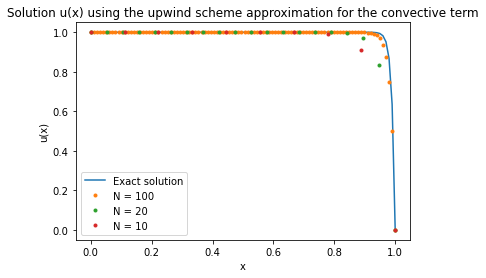

In [7]:
# First I again define the necessary variables and the function
def u(x):
    F = (np.exp(x/e)-np.exp(1/e))/(1-np.exp(1/e))
    return F
e = 1/100
h = np.array([1/10, 1/20, 1/100])
x1 = np.linspace(0, 1, 100)
x2 = np.linspace(0, 1, 20)
x3 = np.linspace(0, 1, 10)

f1 = np.zeros(100)
f1[0] = 1
f2 = np.zeros(20)
f2[0] = 1
f3 = np.zeros(10)
f3[0] = 1

# The convection terms using the upwind scheme
c1 = 1/h[2]*np.diag(np.ones(100), k = 0)
cc1 = -1/h[2]*np.diag(np.ones(99), k = -1)

c2 = 1/h[1]*np.diag(np.ones(20), k = 0)
cc2 = -1/h[1]*np.diag(np.ones(19), k = -1)

c3 = 1/h[0]*np.diag(np.ones(10), k = 0)
cc3 = -1/h[0]*np.diag(np.ones(9), k = -1)

# The diffusion terms for the solution
d1 = -e/(h[2]**2)*np.diag(np.ones(99), k = 1)
dd1 = -e/(h[2]**2)*np.diag(np.ones(99), k = -1)
ddd1 = 2*e/(h[2]**2)*np.diag(np.ones(100))

d2 = -e/(h[1]**2)*np.diag(np.ones(19), k = 1)
dd2 = -e/(h[1]**2)*np.diag(np.ones(19), k = -1)
ddd2 = 2*e/(h[1]**2)*np.diag(np.ones(20))

d3 = -e/(h[0]**2)*np.diag(np.ones(9), k = 1)
dd3 = -e/(h[0]**2)*np.diag(np.ones(9), k = -1)
ddd3 = 2*e/(h[0]**2)*np.diag(np.ones(10))

# The global matrices
A1 = c1 + cc1 + d1 + dd1 + ddd1
A1[0,0] = 1
A1[0,1] = 0
A1[-1,-1] = 1
A1[-1,-2] = 0

A2 = c2 + cc2 + d2 + dd2 + ddd2
A2[0,0] = 1
A2[0,1] = 0
A2[-1,-1] = 1
A2[-1,-2] = 0

A3 = c3 + cc3  + d3 + dd3 + ddd3
A3[0,0] = 1
A3[0,1] = 0
A3[-1,-1] = 1
A3[-1,-2] = 0

# Lastly I plot the figures
plt.figure()
plt.plot(x1, u(x1), label = 'Exact solution')
plt.plot(x1, np.linalg.solve(A1,f1), '.', label = 'N = 100')
plt.plot(x2, np.linalg.solve(A2,f2), '.', label = 'N = 20')
plt.plot(x3, np.linalg.solve(A3,f3), '.', label = 'N = 10')
plt.title('Solution u(x) using the upwind scheme approximation for the convective term')
plt.xlabel('x')
plt.ylabel('u(x)')
plt.legend()

## Section 3/: Other Models 

More later. 

## References 

To be extended. 

1. [convection-diffusion equation on wiki](https://en.wikipedia.org/wiki/Convection–diffusion_equation)
2. [2D Navier-Stokes Solved by pypde](https://pypde.readthedocs.io/en/latest/pages/example_code.html#navier-stokes-2d-parabolic)
3. add references to NGSolve, Fenics and FireDrake among others; 